# Early Count Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#Recent-polling-data" data-toc-modified-id="Recent-polling-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Recent polling data</a></span></li><li><span><a href="#Latest-AEC-national-count-daya" data-toc-modified-id="Latest-AEC-national-count-daya-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Latest AEC national count daya</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally-by-party" data-toc-modified-id="First-preference-votes-nationally-by-party-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>First preference votes nationally by party</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li></ul></li></ul></li><li><span><a href="#Explore-primary-polls" data-toc-modified-id="Explore-primary-polls-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explore primary polls</a></span></li><li><span><a href="#Explore-2pp-Polls" data-toc-modified-id="Explore-2pp-Polls-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Explore 2pp Polls</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# system imports
from pathlib import Path
import itertools
import numbers

# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun May 22 2022 17:53:55

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

pandas    : 1.4.2
matplotlib: 3.5.2
numpy     : 1.22.3

Watermark: 2.3.0



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

## Get data

### Recent polling data

In [5]:
FINAL_POLLING_PERIOD = 4 # days - polls in last six days

def get_last_polls():
    current_polls = f'{PUBLIC_DATA_DIR}primary_vote.csv' 
    polls = pd.read_csv(current_polls, parse_dates=['Mean Date'], index_col=0)
    final_date = polls['Mean Date'].max()
    start_date = final_date - pd.Timedelta(days=FINAL_POLLING_PERIOD)
    retain_polls_mask = ((polls['Mean Date'] >= start_date) 
                         & (polls['Mean Date'] <= final_date))
    return polls[retain_polls_mask]

In [6]:
polls = get_last_polls()
PRIMARIES = {
    'Primary vote L/NP': 'Coalition',
    'Primary vote ALP': 'Labor',
    'Primary vote GRN': 'Green',
    'Primary vote ONP': 'One Nation',
    'Primary vote UAP': 'UAP',
    'Primary vote OTH': 'Other',
}
primary_polls = polls.rename(columns=PRIMARIES)
primary_polls_final_mean = primary_polls[PRIMARIES.values()].mean()
primary_polls_final_mean

Coalition     35.410622
Labor         34.989508
Green         12.363767
One Nation     4.872336
UAP            2.853242
Other          9.510525
dtype: float64

In [7]:
primary_polls.columns


Index(['Coalition', 'Labor', 'Green', 'One Nation', 'UAP', 'Other', 'Date',
       'Mean Date', 'Brand', 'Interview mode', 'Sample size',
       'Calculated 2pp L/NP', 'Calculated 2pp ALP'],
      dtype='object')

### Latest AEC national count daya

#### First preference votes nationally by party

In [8]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [9]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [10]:
# current state of primary votes
total_votes = houseFirstPrefsByParty['TotalVotes'].sum()
primary_tally = {}
for label, group in groups.items():
    primary_tally[label] = (
        houseFirstPrefsByParty
        .loc[group, 'TotalVotes']
        .sum() 
        / total_votes * 100
    )
primary_tally = pd.Series(primary_tally)
primary_tally

Coalition     35.612114
Labor         32.852475
Green         11.944732
One Nation     4.924097
UAP            4.199055
Other         10.467528
dtype: float64

#### Two party preferred votes by state

In [11]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing
0,NSW,New South Wales,1388115,48.37,1481882,51.63,2869997,-3.41
1,VIC,Victoria,1071236,45.60,1278023,54.40,2349259,-1.26
2,QLD,Queensland,969714,53.31,849293,46.69,1819007,-5.13
3,WA,Western Australia,441833,43.81,566650,56.19,1008483,-11.74
4,SA,South Australia,304618,43.91,389145,56.09,693763,-5.38
5,TAS,Tasmania,112027,48.84,117349,51.16,229376,4.80
6,ACT,Australian Capital Territory,58581,35.42,106803,64.58,165384,-2.97
7,NT,Northern Territory,40701,44.47,50822,55.53,91523,-1.33


In [12]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)
labor_tpp_election

52.45557719302657

## Explore primary polls

In [13]:
colours = {
    'Coalition': 'royalblue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}


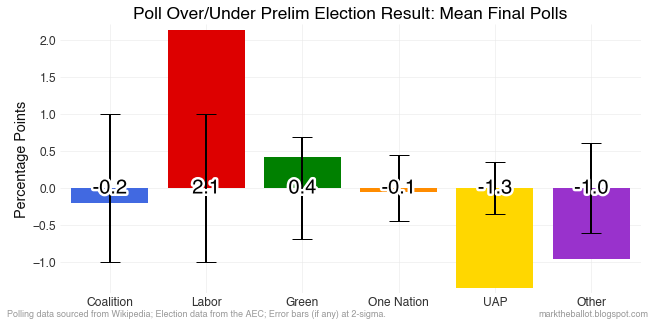

In [14]:
def difference_plot(polls, election, sample_size=None, **kwargs):
    
    SIGMA = 2
    compar = polls - election
    colors = kwargs['colors'] if 'colors' in kwargs else 'darkcyan'
    if type(colors) is str:
        colors = pd.Series([colors]*len(compar), index=compar.index)

    fig, ax = common.initiate_plot()
    for x, y in compar.iteritems():
        ax.bar(x, y, color=colors[x])
        text = ax.text(x, 0, f'{y:0.1f}', ha='center', va='center',
            fontsize=20)
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
        
        if sample_size is not None:
            ss = sample_size if isinstance(sample_size, numbers.Number) else sample_size[x]
            p = polls[x] / 100
            z = np.sqrt((p*(1-p))/ss) * 100
            ax.errorbar(x, 0, yerr=SIGMA*z, ecolor='black', capsize=10)
        
    title = kwargs['title'] if 'title' in kwargs else None
    common.plot_finalise(
        ax, 
        title=title, 
        ylabel='Percentage Points', 
        lfooter='Polling data sourced from Wikipedia; '
                'Election data from the AEC; '
                f'Error bars (if any) at {SIGMA}-sigma.', 
    )

difference_plot(primary_polls_final_mean, primary_tally, 
                primary_polls['Sample size'].sum(), 
                colors=colours,
                title='Poll Over/Under Prelim Election Result: Mean Final Polls')

In [15]:
primary_polls.columns

Index(['Coalition', 'Labor', 'Green', 'One Nation', 'UAP', 'Other', 'Date',
       'Mean Date', 'Brand', 'Interview mode', 'Sample size',
       'Calculated 2pp L/NP', 'Calculated 2pp ALP'],
      dtype='object')

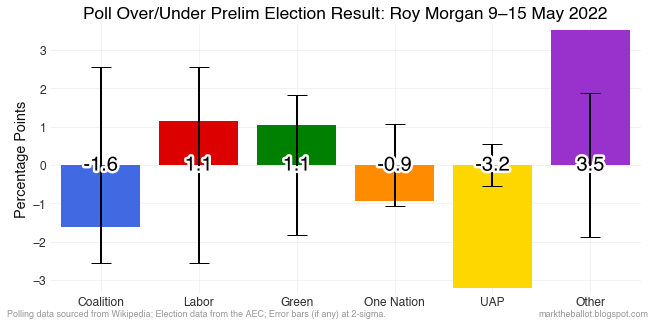

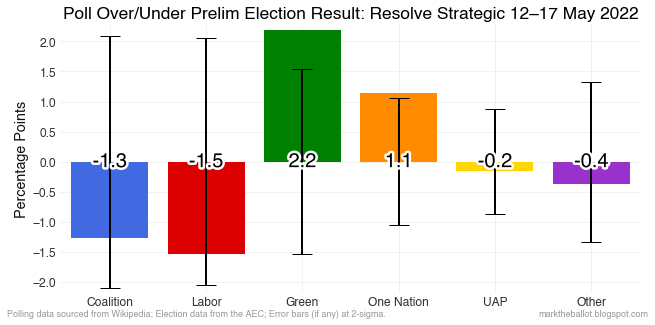

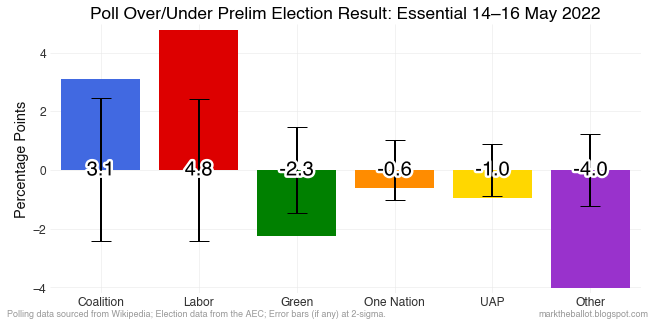

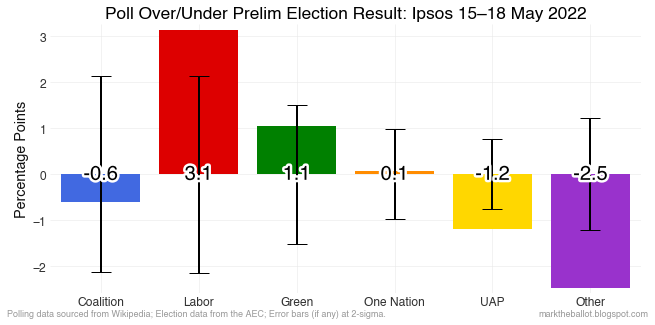

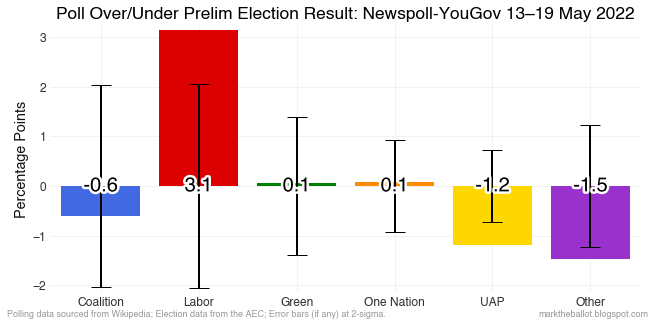

In [16]:
primary_polls.index = primary_polls['Brand'] + ' ' + primary_polls['Date']
for name, poll in primary_polls.iterrows():
    title = f'Poll Over/Under Prelim Election Result: {name}'
    sample_size = poll['Sample size']
    difference_plot(poll[PRIMARIES.values()], primary_tally, 
                    sample_size=sample_size, 
                    colors=colours,
                    title=title)

## Explore 2pp Polls

In [17]:
MFP = 'Mean final polls'
tpp = primary_polls.copy()
tpp.index =  tpp['Brand'] + '\n' +  tpp['Date']
addition = pd.Series([np.nan]*len(tpp.columns), index=tpp.columns, name=MFP)
addition['Sample size'] = tpp['Sample size'].sum()
addition['Calculated 2pp ALP'] = tpp['Calculated 2pp ALP'].mean()
addition = pd.DataFrame(addition).T
tpp = pd.concat([tpp, addition])

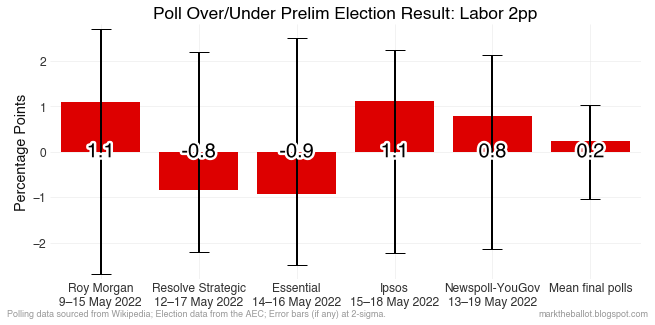

In [18]:
title = 'Poll Over/Under Prelim Election Result: Labor 2pp'
sample_size = poll['Sample size']
difference_plot(tpp['Calculated 2pp ALP'], labor_tpp_election, 
                    sample_size=tpp['Sample size'], 
                    colors='#dd0000',
                    title=title)
